In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
import cv2
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import ntpath
import random
import os

C:\Users\12mik\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
cols= ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data= pd.read_csv('driving_log.csv', names= cols)
# to see full image
pd.set_option('display.max_colwidth', -1)

In [3]:
data.head()

center  \
0  D:\Springboard\projects\Capstone2\Driving\IMG\center_2019_04_24_16_24_42_393.jpg   
1  D:\Springboard\projects\Capstone2\Driving\IMG\center_2019_04_24_16_24_42_815.jpg   
2  D:\Springboard\projects\Capstone2\Driving\IMG\center_2019_04_24_16_24_42_914.jpg   
3  D:\Springboard\projects\Capstone2\Driving\IMG\center_2019_04_24_16_24_43_019.jpg   
4  D:\Springboard\projects\Capstone2\Driving\IMG\center_2019_04_24_16_24_43_122.jpg   

                                                                              left  \
0   D:\Springboard\projects\Capstone2\Driving\IMG\left_2019_04_24_16_24_42_393.jpg   
1   D:\Springboard\projects\Capstone2\Driving\IMG\left_2019_04_24_16_24_42_815.jpg   
2   D:\Springboard\projects\Capstone2\Driving\IMG\left_2019_04_24_16_24_42_914.jpg   
3   D:\Springboard\projects\Capstone2\Driving\IMG\left_2019_04_24_16_24_43_019.jpg   
4   D:\Springboard\projects\Capstone2\Driving\IMG\left_2019_04_24_16_24_43_122.jpg   

                                                                              right  \
0   D:\Springboard\projects\Capstone2\Driving\IMG\right_2019_04_24_16_24_42_393.jpg   
1   D:\Springboard\projects\Capstone2\Driving\IMG\right_2019_04_24_16_24_42_815.jpg   
2   D:\Springboard\projects\Capstone2\Driving\IMG\right_2019_04_24_16_24_42_914.jpg   
3   D:\Springboard\projects\Capstone2\Driving\IMG\right_2019_04_24_16_24_43_019.jpg   
4   D:\Springboard\projects\Capstone2\Driving\IMG\right_2019_04_24_16_24_43_122.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0.0      0.000022  
1  0.0       0.0       0.0      0.000025  
2  0.0       0.0       0.0      0.000024  
3  0.0       0.0       0.0      0.000023  
4  0.0       0.0       0.0      0.000022

In [5]:
# function to grab relevent path of images
def path_split(path):
    head, tail= ntpath.split(path)
    return tail
data.center= data['center'].apply(path_split)
data.left= data['left'].apply(path_split)
data.right= data['right'].apply(path_split)
# export formatted data to excel for upload to github
data.to_excel('spreadsheet_data.xlsx')

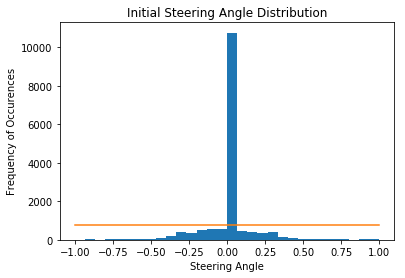

In [51]:
samples_per_bin=750
plt.hist(data.steering, bins=30)
plt.xlabel('Steering Angle')
plt.ylabel('Frequency of Occurences')
plt.title('Initial Steering Angle Distribution')
# data is heavily skewed to the zero, visualize threshold to cut exessively represented data
plt.plot((np.min(data.steering), np.max(data.steering)), (samples_per_bin, samples_per_bin))
plt.savefig('init_distribution.png')

Need to balance data so the model sees a better distribution of steering angles and does not overfit on the 0.00 angle

In [7]:
# get bin edges of histogram for filtering
num_bins= 30
hist, bins = np.histogram(data.steering, num_bins)
print('hist distriubtion: ', hist, '\n','bin distribution: ', bins)

hist distriubtion:  [   14    17    12    26    45    58    45    60   118   177   426   335
   514   539   543 10764   460   428   332   392   135    80    43    33
    37    27    22    12    19    46] 
 bin distribution:  [-1.         -0.93333333 -0.86666667 -0.8        -0.73333333 -0.66666667
 -0.6        -0.53333333 -0.46666667 -0.4        -0.33333333 -0.26666667
 -0.2        -0.13333333 -0.06666667  0.          0.06666667  0.13333333
  0.2         0.26666667  0.33333333  0.4         0.46666667  0.53333333
  0.6         0.66666667  0.73333333  0.8         0.86666667  0.93333333
  1.        ]


In [53]:
print('total data: ', len(data))
remove_list= []
for i in range(num_bins):
    list_= []
    # aggregate data falling in each respective bin
    for j in range(len(data.steering)):
        if data.steering[j] >= bins[i] and data.steering[j] < bins[i+1]:
            list_.append(j)
    x = shuffle(list_)[samples_per_bin:]
    remove_list.extend(x)
print('Removed: ', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining: ', len(data))

total data:  15759
Removed:  10014
remaining:  5745


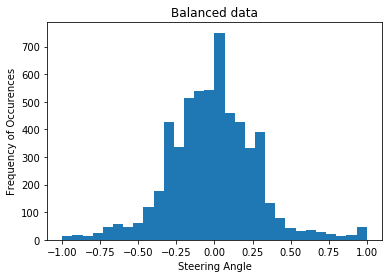

In [56]:
plt.hist(data.steering, bins= 30)
plt.title('Balanced data')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency of Occurences')
plt.savefig('balanced_distribution.png')
plt.show()

Could potentially need to do *recovery laps* where I collect data of the car attempting to get back on the track, or recovering. I would not want the data of it getting off track, only the data of it getting back on track. This would simply translates to only recording the recovery process.

Gather images as captured by the car's camera. To keep computation costs low, I will exclusively use the center camera images to train my model. 

In [10]:
def load_img(datadir, df):
    img_path= []
    steering= []
    for i in range(len(data)):
        index_data= data.iloc[i]
        center, left, right= index_data[0], index_data[1], index_data[2]
        img_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(index_data[3]))
    img_path= np.asarray(img_path)
    steering= np.asarray(steering)
    return img_path, steering

In [9]:
data.iloc[400,0].strip()

'center_2019_04_24_16_25_23_684.jpg'

In [15]:
center= mpimg.imread(os.path.join('IMG',data.iloc[400,0].strip()))
left= mpimg.imread(os.path.join('IMG',data.iloc[400,1].strip()))
right= mpimg.imread(os.path.join('IMG',data.iloc[400,2].strip()))

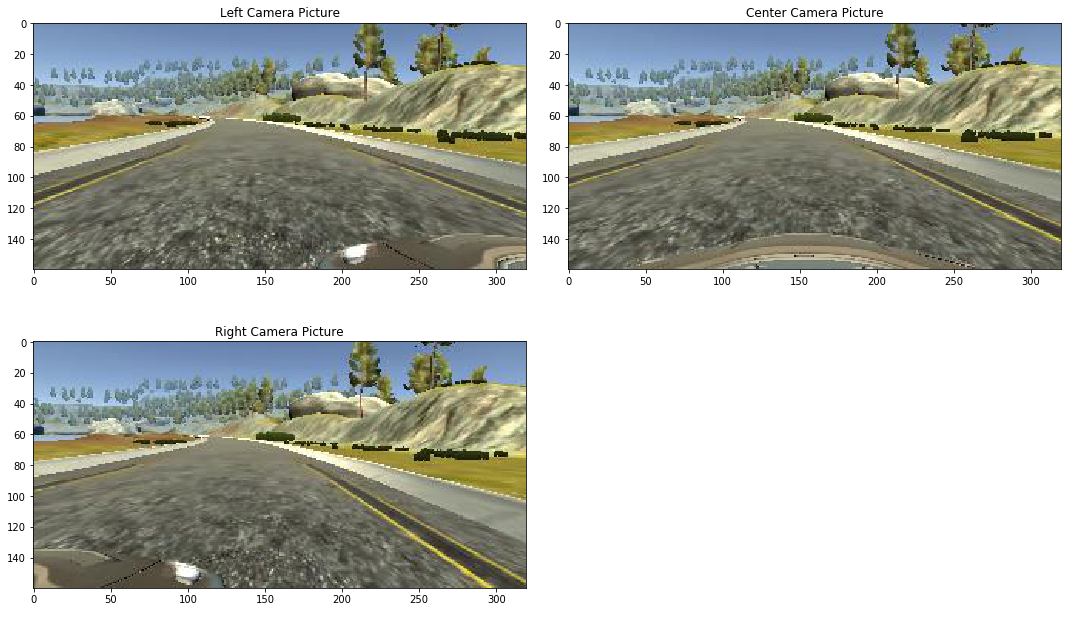

In [27]:
fig, axes = plt.subplots(2,2, figsize= (15,9))
fig.tight_layout()
axes[0][0].imshow(left)
axes[0][0].set_title('Left Camera Picture')
axes[0][1].imshow(center)
axes[0][1].set_title('Center Camera Picture')
axes[1][0].imshow(right)
axes[1][0].set_title('Right Camera Picture')
axes[1][1].axis('off')
plt.savefig('Camera.png')
plt.show()

In [11]:
images, steerings= load_img('IMG', data)

Set up a train-test split on the center camera image data -> 80% train, 20% validation

In [14]:
X_train_init, X_val_init, y_train_init, y_val_init= train_test_split(images, steerings, test_size= 0.2, random_state= 42)

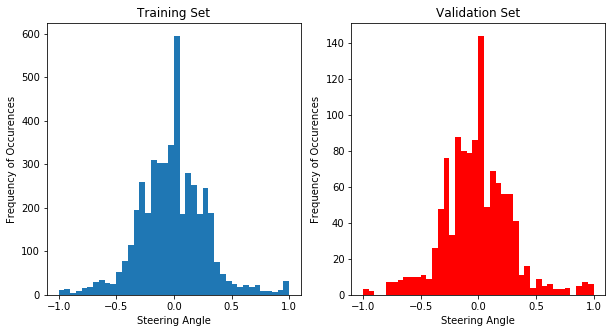

In [59]:
fig, axes= plt.subplots(1, 2, figsize= (10,5))
axes[0].hist(y_train_init, bins= 40, width= .05)
axes[0].set_xlabel('Steering Angle')
axes[0].set_ylabel('Frequency of Occurences')
axes[0].set_title('Training Set')
axes[1].hist(y_val_init, bins= 40, width= .05, color='red')
axes[1].set_xlabel('Steering Angle')
axes[1].set_ylabel('Frequency of Occurences')
axes[1].set_title('Validation Set')
plt.savefig('train_val.png')

Set up the preprocess function, which will crop the image to focus on most important parts of the image. This function will also convert the RGB images into the more useful YUV color-scheme

In [45]:
def img_preprocess(img):
    # crop image to cut out car hood and scenary
    img= img[60:135,:,:]
    img= cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img= cv2.GaussianBlur(img, (3,3), 0)
    # Resize image to fit NVIDIA standard
    img= cv2.resize(img,(200,66))
    img= img/255
    return img

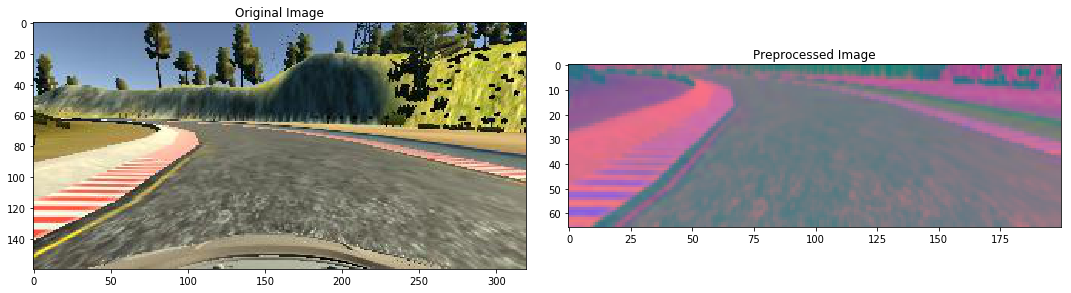

In [46]:
image = images[100]
orig= mpimg.imread(image)
prep= img_preprocess(orig)

fig, axes = plt.subplots(1,2, figsize= (15,10))
fig.tight_layout()
axes[0].imshow(orig)
axes[0].set_title('Original Image')
axes[1].imshow(prep)
axes[1].set_title('Preprocessed Image')
plt.savefig('Original vs Preprocessed image')
plt.show()

This is a regression type classification (only focusing on steering, which can take any value (-1,1)) so I will be using the mean squared error loss function to train the deep learning model. Furthermore, our model is a behavioral cloning model i.e. it is cloning my driving behavior in the simulation. Several autonomous driving cars today implement the NVIDIA model to optimize their own steering algorithms. I will do the same here. 

Using activation function relu with minimal dropouts indicated overfitting- training loss was much lower than validation loss. Solution- use elu activation function, increase dropout layers, and increase number of training data.

After simulating the model, I have determined that the trained model does not have enough driving data to perform very well. While it is able to navigate the track initially, it fails to make a complete lap. I will proceed to augment the data with the library **imgaug**. Augmenting the training set will help the model generalizes to new environments as well as perform better. 

In [17]:
from imgaug import augmenters as ia

In [18]:
def zoom(img):
    zoom= ia.Affine(scale= (1,1.3))
    image= zoom.augment_image(img)
    return image

def pan(img):
    pan= ia.Affine(translate_percent= {'x': (-.1,.1), 'y': (-.1,.1)})
    image= pan.augment_image(img)
    return image

def sharp(img):
    sharp= ia.Sharpen(alpha=(0,1), lightness= (.75,2))
    image= sharp.augment_image(img)
    return(image)

def dark(img):
    darkness= ia.Multiply((.2,1))
    image= darkness.augment_image(img)
    return image

def bright(img):
    brightness= ia.Multiply((1,1.5))
    image= brightness.augment_image(img)
    return image

def flip(img, steering):
    image= cv2.flip(img,1)
    steering= -steering
    return image, steering

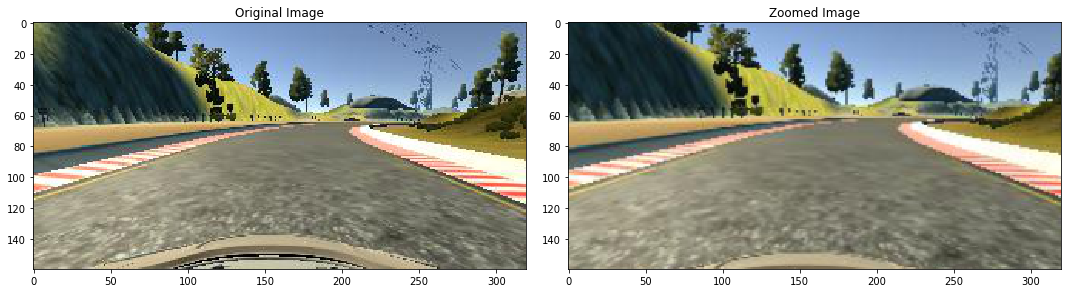

In [60]:
image= images[random.randint(0,1000)]
og= mpimg.imread(image)
zm= zoom(og)
fig, axes= plt.subplots(1,2, figsize= (15,10))
fig.tight_layout()

axes[0].imshow(og)
axes[0].set_title('Original Image')
axes[1].imshow(zm)
axes[1].set_title('Zoomed Image')
plt.savefig('zoom.png')
plt.show()

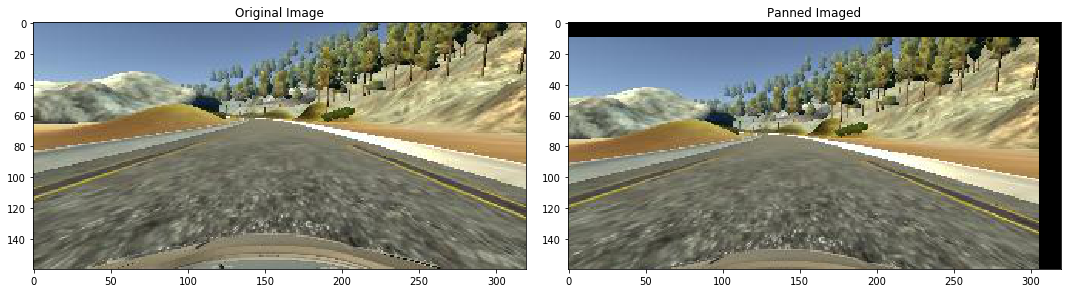

In [61]:
image= images[random.randint(0,1000)]
og= mpimg.imread(image)
pn= pan(og)
fig, axes= plt.subplots(1,2, figsize= (15,10))
fig.tight_layout()

axes[0].imshow(og)
axes[0].set_title('Original Image')
axes[1].imshow(pn)
axes[1].set_title('Panned Imaged')
plt.savefig('pan.png')
plt.show()

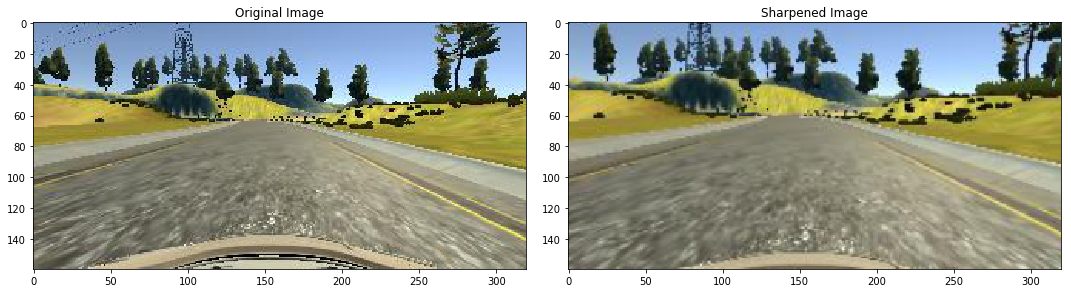

In [62]:
image= images[random.randint(0,1000)]
og= mpimg.imread(image)
sh= zoom(og)
fig, axes= plt.subplots(1,2, figsize= (15,10))
fig.tight_layout()

axes[0].imshow(og)
axes[0].set_title('Original Image')
axes[1].imshow(sh)
axes[1].set_title('Sharpened Image')
plt.savefig('sharp.png')
plt.show()

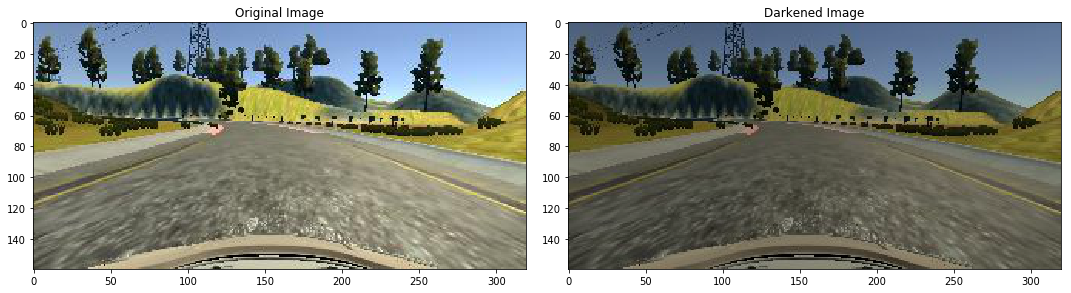

In [63]:
image= images[random.randint(0,1000)]
og= mpimg.imread(image)
dk= dark(og)
fig, axes= plt.subplots(1,2, figsize= (15,10))
fig.tight_layout()

axes[0].imshow(og)
axes[0].set_title('Original Image')
axes[1].imshow(dk)
axes[1].set_title('Darkened Image')
plt.savefig('dark.png')
plt.show()

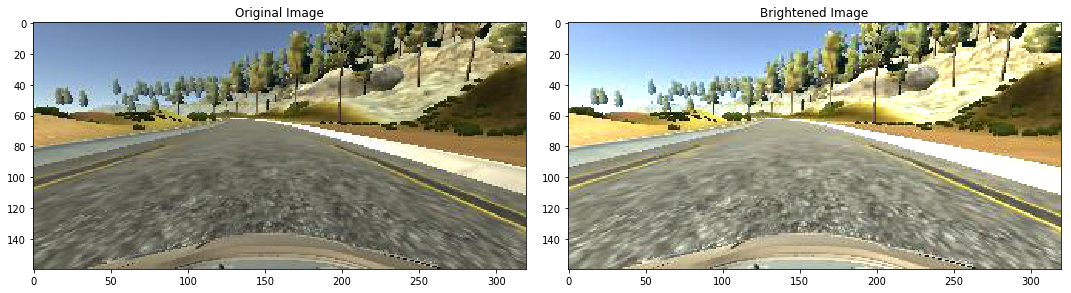

In [65]:
image= images[random.randint(0,1000)]
og= mpimg.imread(image)
br= bright(og)
fig, axes= plt.subplots(1,2, figsize= (15,10))
fig.tight_layout()

axes[0].imshow(og)
axes[0].set_title('Original Image')
axes[1].imshow(br)
axes[1].set_title('Brightened Image')
plt.savefig('bright.png')
plt.show()

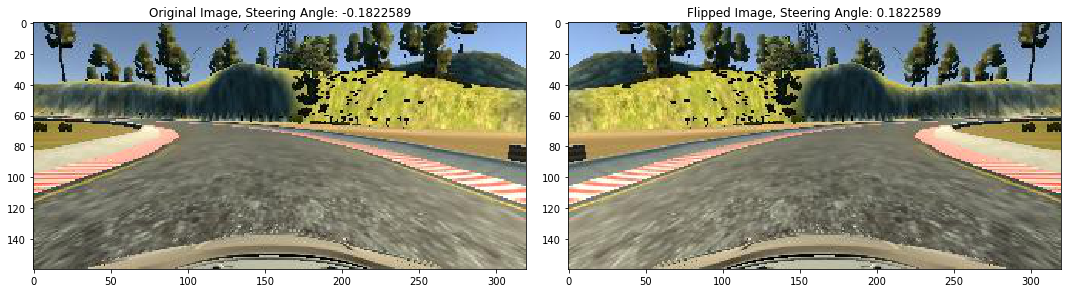

In [77]:
index= random.randint(0,1000)
image= images[index]
steer_ang= steerings[index]

og= mpimg.imread(image)
flipped_img, flipped_steer_ang= flip(og, steer_ang)

fig, axes= plt.subplots(1,2, figsize= (15,10))
fig.tight_layout()

axes[0].imshow(og)
axes[0].set_title('Original Image, '+'Steering Angle: '+ str(steer_ang))
axes[1].imshow(flipped_img)
axes[1].set_title('Flipped Image, '+'Steering Angle: ' +str(flipped_steer_ang))
plt.savefig('flip.png')
plt.show()

Implement an augmentation function which will apply a random combination of the above augmentations to an image. Note that each augmentation has 50% chance of being applied. 

In [25]:
def augment(img, steer_ang):
    image= mpimg.imread(img)
    if np.random.rand() < .5:
        image= pan(image)
    if np.random.rand() < .5:
        image= zoom(image)
    if np.random.rand() < .5:
        image= sharp(image)
    if np.random.rand() < .5:
        image= dark(image)
    if np.random.rand() < .5:
        image= bright(image)
    if np.random.rand() < .5:
        image, steer_ang = flip(image, steer_ang)
    return image, steer_ang

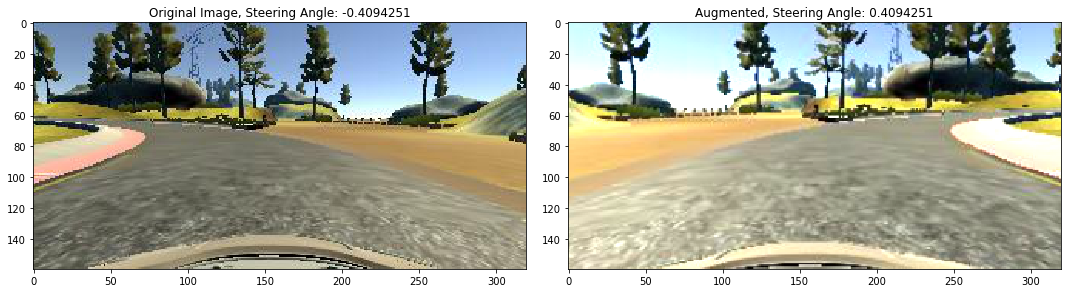

In [99]:
index= random.randint(0,1000)
image= images[index]
og= mpimg.imread(image)
steer_ang= steerings[index]
aug_img, flipped_steer_ang= augment(image, steer_ang)

fig, axes= plt.subplots(1,2, figsize= (15,10))
fig.tight_layout()

axes[0].imshow(og)
axes[0].set_title('Original Image, '+'Steering Angle: '+ str(steer_ang))
axes[1].imshow(aug_img)
axes[1].set_title('Augmented, '+'Steering Angle: ' +str(flipped_steer_ang))
plt.savefig('aug.png')
plt.show()

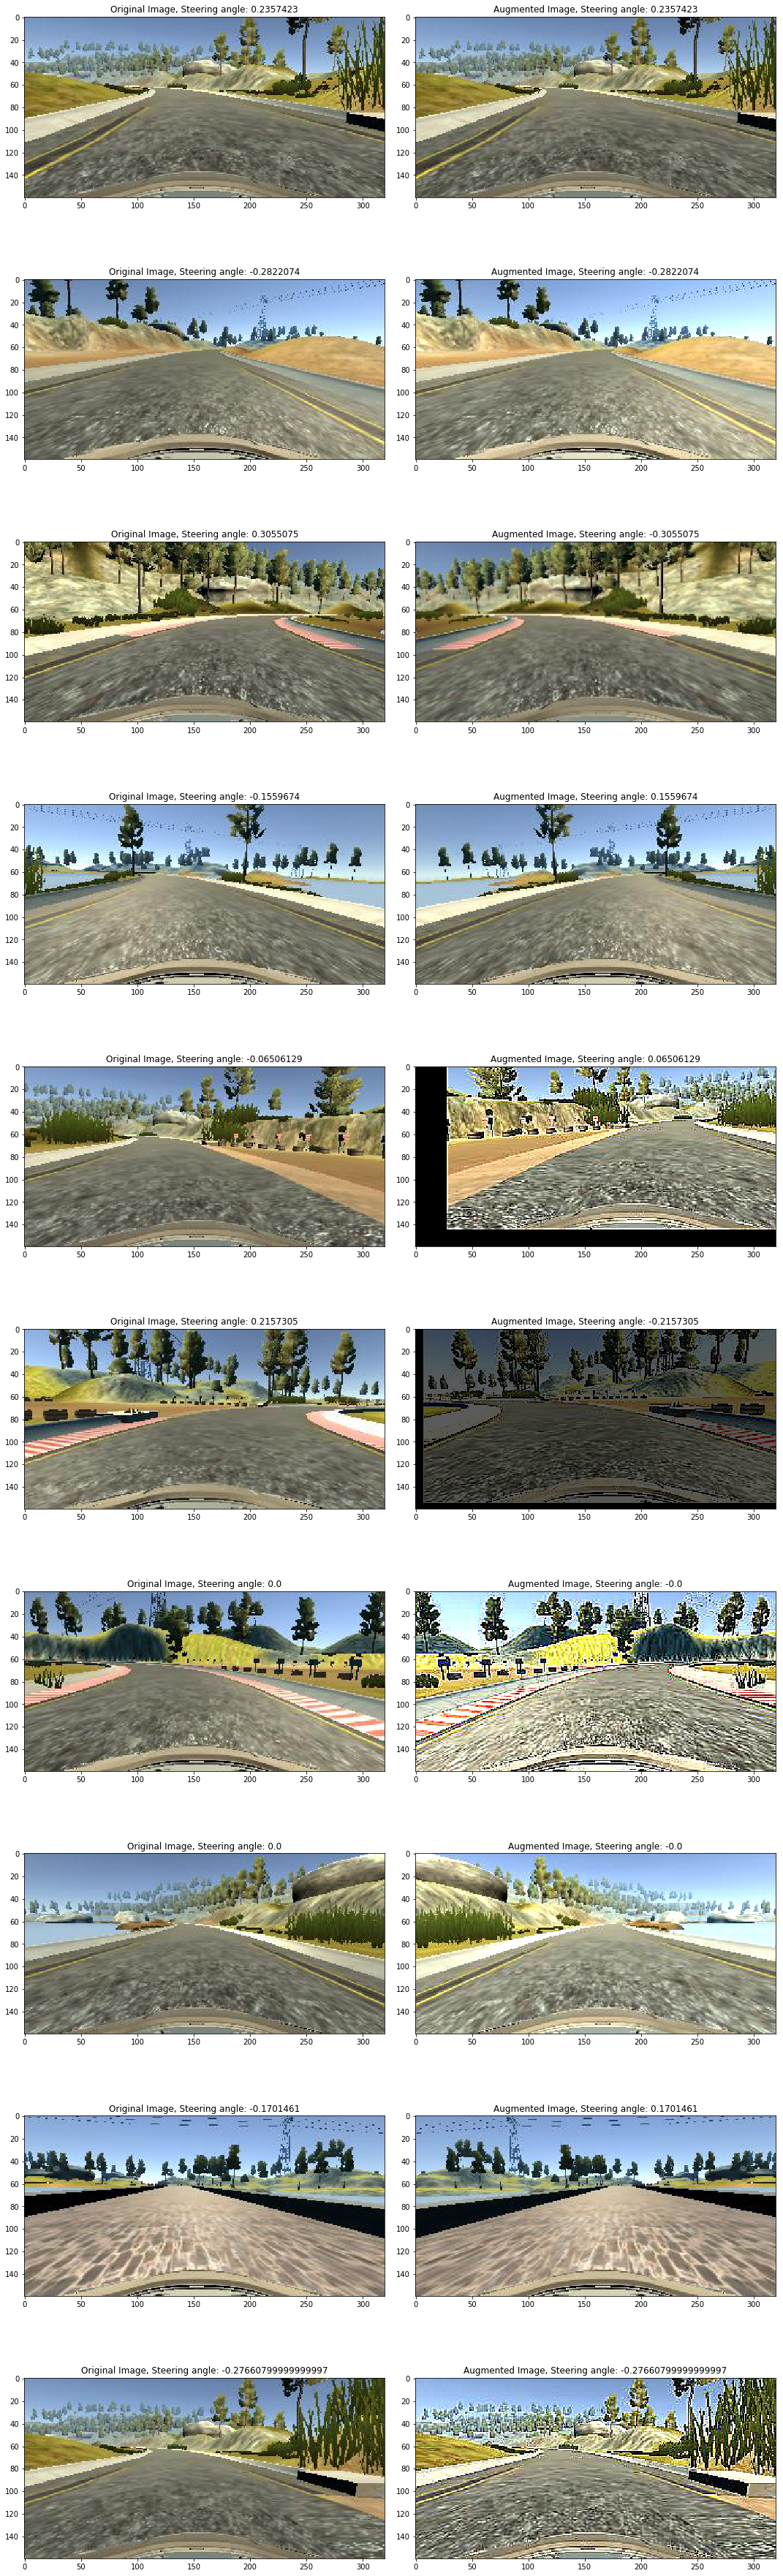

In [26]:
fig, axes= plt.subplots(10,2, figsize= (15,50) )
fig.tight_layout()

for i in range(10):
    rand= random.randint(0,len(images)-1)
    rnd_img= images[rand]
    rnd_steer= steerings[rand]
    
    orig= mpimg.imread(rnd_img)
    aug, aug_steer = augment(rnd_img, rnd_steer)
    
    axes[i][0].imshow(orig)
    axes[i][0].set_title('Original Image, '+'Steering angle: '+ str(rnd_steer))
    axes[i][1].imshow(aug)
    axes[i][1].set_title('Augmented Image, '+'Steering angle: '+ str(aug_steer))

Define batch generator to generate augmented images on the fly and thus reduce memory costs in the later implemented fit generator function. Note that the batch generator applied the augmentation to the training data, but ignores the augmentation on the validation set. This is so that validation set is tested on an image very close to what it will see on the track.

In [27]:
def batch_generator(images, steerings, batch_size, isTraining):
    while True:
        batch_img= []
        batch_steer= []
        
        for i in range(batch_size):
            index= random.randint(0, len(images)-1)
            
            if isTraining:
                image, steering= augment(images[index], steerings[index])
            else:
                image= mpimg.imread(images[index])
                steering= steerings[index]
    
            image= img_preprocess(image)
            batch_img.append(image)
            batch_steer.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steer))

In [28]:
x_train_gen, y_train_gen= next(batch(X_train_init, y_train_init, 1, 1))
x_val_gen, y_val_gen= next(batch(X_val_init, y_val_init, 1, 0))

Visualize the training image vs validation image. Note that the validation image does not get any augmentation applied to it. 

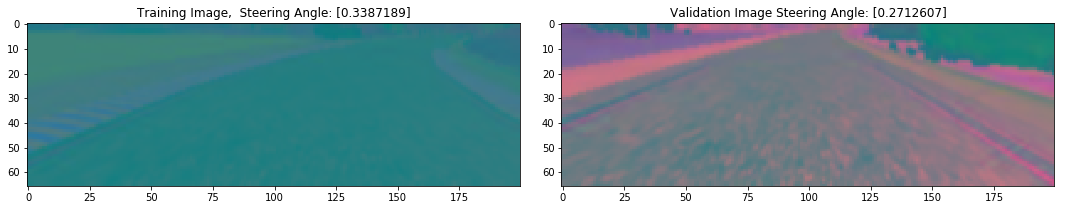

In [29]:
fig, axes= plt.subplots(1,2, figsize= (15,10))
fig.tight_layout()

axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training Image, '+' Steering Angle: '+str(y_train_gen))
axes[1].imshow(x_val_gen[0])
axes[1].set_title('Validation Image' +' Steering Angle: '+str(y_val_gen))
plt.show()

Construct the NVIDIA ADS architecture as seen here https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf

In [30]:
def aug_nvidia():
    
    model= Sequential()
    
    model.add(Convolution2D(24, 5, 5, subsample= (2,2), input_shape= (66,200,3), activation= 'elu' ))
    model.add(Convolution2D(36, 5,5, subsample= (2,2), activation= 'elu'))
    model.add(Convolution2D(48, 5,5, subsample= (2,2), activation= 'elu'))
    model.add(Convolution2D(64, 3,3, activation= 'elu'))
    model.add(Convolution2D(64, 3,3, activation= 'elu'))
    
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    
    model.add(Dense(50, activation='elu'))
    
    model.add(Dense(10, activation='elu'))
    
    model.add(Dense(1))
    
    model.compile(loss= 'mse', optimizer= Adam(lr= 5e-4))
    
    return model

In [31]:
# get model summary to visualize data transformation through the model
aug_model= aug_nvidia()
print(aug_model.summary())

C:\Users\12mik\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
C:\Users\12mik\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  """
C:\Users\12mik\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  
C:\Users\12mik\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  import sys
C:\Users\12mik\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
__________

In [32]:
# call the fit generator to apply the batch generator on the training and validation dataset
aug_history= aug_model.fit_generator(batch_generator(X_train_init, y_train_init, 100, 1) , steps_per_epoch= 400, epochs=10, validation_data= batch_generator(X_val_init, y_val_init, 100,0), validation_steps= 200, verbose= 1, shuffle=1)

Epoch 1/10
400/400 [==============================] - 312s 780ms/step - loss: 0.0876 - val_loss: 0.0594
Epoch 2/10
400/400 [==============================] - 149s 374ms/step - loss: 0.0679 - val_loss: 0.0534
Epoch 3/10
400/400 [==============================] - 150s 375ms/step - loss: 0.0620 - val_loss: 0.0548
Epoch 4/10
400/400 [==============================] - 150s 374ms/step - loss: 0.0589 - val_loss: 0.0556
Epoch 5/10
400/400 [==============================] - 150s 375ms/step - loss: 0.0578 - val_loss: 0.0482
Epoch 6/10
400/400 [==============================] - 150s 374ms/step - loss: 0.0538 - val_loss: 0.0451
Epoch 7/10
400/400 [==============================] - 150s 376ms/step - loss: 0.0513 - val_loss: 0.0484
Epoch 8/10
400/400 [==============================] - 150s 375ms/step - loss: 0.0495 - val_loss: 0.0444
Epoch 9/10
400/400 [==============================] - 150s 376ms/step - loss: 0.0490 - val_loss: 0.0419
Epoch 10/10
400/400 [==============================] - 150s 375m

After model training and validation is complete I plot the respective loss function to gain an initial evaluation of the model

Text(0.5,15,'Epoch')

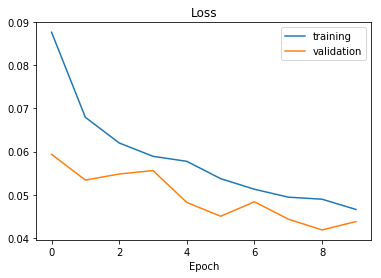

In [36]:
plt.plot(aug_history.history['loss'])
plt.plot(aug_history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.savefig('final.png')
plt.xlabel('Epoch')

In [34]:
aug_model.save('model_sim/model.h5')

The model training and validation loss plot shows a good trend. It appears the model neither overfit or underfit on the data, and I am confident that it will perform well on the simulated track. The next step is to write the Flask and Socketio connection for the saved model to connect to the simulation. The performance in the simulation will prove to be the true test of the model. 